# MDA 2021
## Pyspark Sample Code
-----------------------------------------------------------------

## Setup
--------------------------------------------------

Let's setup Spark on your Colab environment.  Run the cell below!

In [16]:
%pip install pyspark
%pip install --upgrade arabic-reshaper
%pip install python-bidi
# !pip install -U -q PyDrive
!sudo apt install openjdk-8-jdk-headless
# !apt install openjdk-8-jdk-headless -qq(
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Note: you may need to restart the kernel to use updated packages.
Requirement already up-to-date: arabic-reshaper in /home/amir/PycharmProjects/big data/hw2/spark/lib/python3.8/site-packages (2.1.3)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~20.04).
The following packages were automatically installed and are no longer required:
  i965-va-driver:i386 intel-media-va-driver:i386 libaom0:i386
  libavcodec58:i386 libavutil56:i386 libcairo-gobject2:i386 libcapi20-3
  libcapi20-3:i386 libcodec2-0.9:i386 libdatrie1:i386 libfaudio0
  libfaudio0:i386 libfribidi0:i386 libgdk-pixbuf2.0-0:i386 libgomp1:i386
  libgraphite2-3:i386 libgsm1:i386 libharfbuzz0b:i386 libigdgmm11:i386
  liblcms2-2:i386 libmp3lame0:i386 libmpg123-0:i386 libnuma1:i386
  l

## For correctly display persian

In [1]:
import arabic_reshaper
from bidi.algorithm import get_display

Now we authenticate a Google Drive client to processing data

**Make sure to follow the interactive instructions.**

## if work on colab

In [4]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


## Check and extract data from drive
--------------------------------------------------

In [3]:
base_path = '/content/drive/My Drive/Colab Notebooks/'

In [4]:
!ls '/content/drive/My Drive/Colab Notebooks/'

ls: cannot access '/content/drive/My Drive/Colab Notebooks/': No such file or directory


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/Data.zip' -d '/content/drive/My Drive/Colab Notebooks/'

Archive:  /content/drive/My Drive/Colab Notebooks/Data.zip
replace /content/drive/My Drive/Colab Notebooks/Traffic.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


the cells above, extract data which is in '/content/drive/My Drive/Test' to /content/drive/My Drive/Test/Traffic.csv  

## Initializing Spark and read data
--------------------------------------------------

In [1]:
from pyspark import SparkContext, SparkConf 
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType
from pyspark.sql.functions import col,current_timestamp,to_date,hour,dayofweek
import  pyspark.sql.functions as f

spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

sc.setLogLevel("WARN")

trafic_schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",IntegerType(),True), \
        StructField("FINAL_CAR_KEY",IntegerType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

In [2]:
trafic=spark.read.csv('Traffic.csv',header=True,schema=trafic_schema)
trafic.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



### company schema

In [3]:
company_schema = StructType([
    StructField("COMPANY_ID", IntegerType(), True),
    StructField("COMPANY_NAME", StringType(), True),
    StructField("ACTIVE_SYSTEM_ID", StringType(), True),
])

company = spark.read.csv('CompanyID.csv', header=True, schema=company_schema)

company = company.withColumn(
    'ACTIVE_SYSTEM_ID', f.split(company.ACTIVE_SYSTEM_ID, "-"))
company.show(1)


+----------+---------------+----------------+
|COMPANY_ID|   COMPANY_NAME|ACTIVE_SYSTEM_ID|
+----------+---------------+----------------+
|        61|دید افزار سیستم|       [81, 102]|
+----------+---------------+----------------+
only showing top 1 row



### system schema

In [4]:
system_schema = StructType([ \
        StructField("SYSTEM_ID", IntegerType(), True), 
        StructField("SYSTEM_NAME",StringType(),True), \
        StructField("ACTIVE_COMPANY_ID",StringType(),True),
    ])

system = spark.read.csv('SystemID.csv', header=True, schema=system_schema)
system = system.withColumn('ACTIVE_COMPANY_ID', f.split(system.ACTIVE_COMPANY_ID , "-"))
system.show(1)


+---------+-------------------+------------------+
|SYSTEM_ID|        SYSTEM_NAME| ACTIVE_COMPANY_ID|
+---------+-------------------+------------------+
|       81|محدوده ‌طرح ‌ترافیک|[61, 62, 161, 274]|
+---------+-------------------+------------------+
only showing top 1 row



### status schema

In [5]:
check_status_schema = StructType([
    StructField("CHECK_STATUS_KEY", IntegerType(), True),
    StructField("CHECK_STATUS_CODE", IntegerType(), True),
    StructField("CHECK_STATUS_NAME", StringType(), True),
    StructField("CHECK_STATUS_TYPE_CODE", IntegerType(), True),
    StructField("CHECK_STATUS_TYPE_NAME", StringType(), True),
])

check_status = spark.read.csv('checkstatus.csv', header=True, schema=check_status_schema)
check_status.show(1)


+----------------+-----------------+--------------------+----------------------+----------------------+
|CHECK_STATUS_KEY|CHECK_STATUS_CODE|   CHECK_STATUS_NAME|CHECK_STATUS_TYPE_CODE|CHECK_STATUS_TYPE_NAME|
+----------------+-----------------+--------------------+----------------------+----------------------+
|               5|                5|اتوماتيک اپراتوري...|                     2|              اتوماتيک|
+----------------+-----------------+--------------------+----------------------+----------------------+
only showing top 1 row



--------------------------------------------------
Good Luck!

# Visualize some data


## how many company work on different systems?

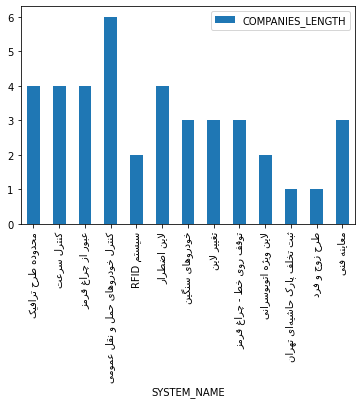

In [ ]:
pd = system.select(system.SYSTEM_NAME, f.size(system.ACTIVE_COMPANY_ID).alias('COMPANIES_LENGTH')).toPandas()
pd['SYSTEM_NAME'] = pd['SYSTEM_NAME'].apply(lambda x : get_display(arabic_reshaper.reshape(x)))
pd.plot(kind= 'bar', x='SYSTEM_NAME', y='COMPANIES_LENGTH')

## how many systems any company work on it?

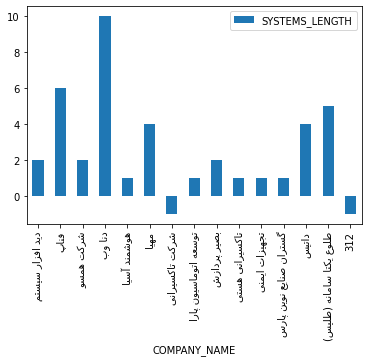

In [ ]:
pd = company.select(company.COMPANY_NAME, f.size(company.ACTIVE_SYSTEM_ID).alias('SYSTEMS_LENGTH')).toPandas()
pd['COMPANY_NAME'] = pd['COMPANY_NAME'].apply(lambda x : get_display(arabic_reshaper.reshape(x)))
pd.plot(kind= 'bar', x='COMPANY_NAME', y='SYSTEMS_LENGTH')

## how many times any company not find plate correctly ?

In [6]:
failed_plate_in_company = trafic.filter((trafic.CHECK_STATUS_KEY != 5) & (trafic.CHECK_STATUS_KEY != 6)).groupBy(
    'COMPANY_ID').agg({'*': 'count'}).withColumnRenamed('count(1)', 'FAILED').join(company, 'COMPANY_ID')


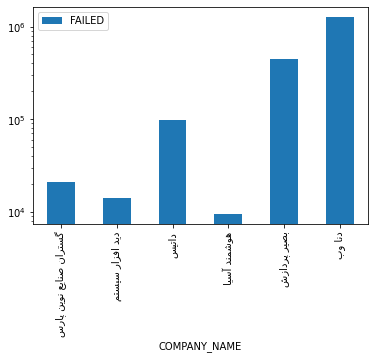

In [ ]:
pd = failed_plate_in_company.toPandas()
pd['COMPANY_NAME'] = pd['COMPANY_NAME'].apply(lambda x : get_display(arabic_reshaper.reshape(x)))
pd.plot(kind= 'bar', x='COMPANY_NAME', y='FAILED', logy=True)

## how many times device of a specific company not find plate correctly and go to manual check?

In [ ]:
manual_plate_in_company = trafic.filter(
    (trafic.CHECK_STATUS_KEY == 0) | (trafic.CHECK_STATUS_KEY == 1) | (trafic.CHECK_STATUS_KEY == 2) | (trafic.CHECK_STATUS_KEY == 3) | (trafic.CHECK_STATUS_KEY == 7)).groupBy(
    'COMPANY_ID').agg({'*': 'count'}).withColumnRenamed('count(1)', 'MANUAL').join(company, 'COMPANY_ID')


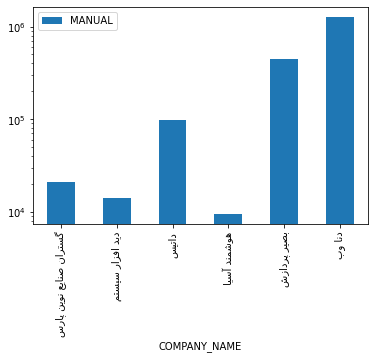

In [ ]:
pd = manual_plate_in_company.toPandas()
pd['COMPANY_NAME'] = pd['COMPANY_NAME'].apply(lambda x : get_display(arabic_reshaper.reshape(x)))
pd.plot(kind= 'bar', x='COMPANY_NAME', y='MANUAL', logy=True)

## top 5 higher failer in device 

In [7]:
failed_device = trafic.filter(
    (trafic.CHECK_STATUS_KEY == 0) | (trafic.CHECK_STATUS_KEY == 1) | (trafic.CHECK_STATUS_KEY == 2) | (trafic.CHECK_STATUS_KEY == 3) | (trafic.CHECK_STATUS_KEY == 7)).groupBy(
    'DEVICE_CODE').agg({'*': 'count'}).withColumnRenamed('count(1)', 'FAILED')

all_device_records = trafic.groupBy('DEVICE_CODE').agg(
    {'*': 'count'}).withColumnRenamed('count(1)', 'RECORDS')


In [8]:
device_failer_rate = failed_device.join(all_device_records, 'DEVICE_CODE').withColumn(
    'RATE', f.col('FAILED') / f.col('RECORDS')).sort('RATE', ascending=False, )


In [9]:
top_5_device_failer_rate = device_failer_rate.filter(device_failer_rate.RATE != 1).limit(20)

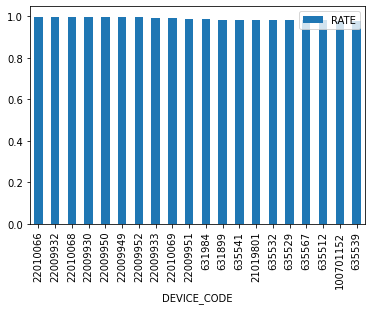

In [ ]:
pd = top_5_device_failer_rate.toPandas()
# pd['COMPANY_NAME'] = pd['COMPANY_NAME'].apply(lambda x : get_display(arabic_reshaper.reshape(x)))
pd.plot(kind= 'bar', x='DEVICE_CODE', y='RATE',)

## top 5 higher success in device

In [10]:
success_device = trafic.filter(
    (trafic.CHECK_STATUS_KEY == 5) | (trafic.CHECK_STATUS_KEY == 6)).groupBy(
    'DEVICE_CODE').agg({'*': 'count'}).withColumnRenamed('count(1)', 'SUCCESSED')


In [11]:
device_success_rate = success_device.join(all_device_records, 'DEVICE_CODE').withColumn(
    'RATE', f.col('SUCCESSED') / f.col('RECORDS')).sort('RATE', ascending=False, )


In [ ]:
top_5_device_success_rate = device_success_rate.filter(device_success_rate.RATE != 1).limit(20)

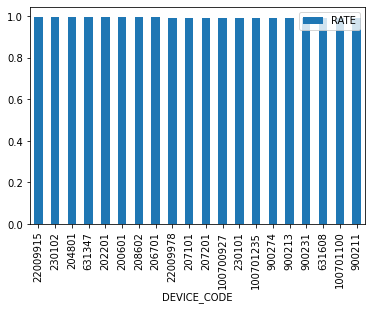

In [ ]:
pd = top_5_device_success_rate.toPandas()
# pd['COMPANY_NAME'] = pd['COMPANY_NAME'].apply(lambda x : get_display(arabic_reshaper.reshape(x)))
pd.plot(kind= 'bar', x='DEVICE_CODE', y='RATE',)

In [ ]:
device_success_rate.summary().show()

+-------+--------------------+-----------------+-----------------+--------------------+
|summary|         DEVICE_CODE|        SUCCESSED|          RECORDS|                RATE|
+-------+--------------------+-----------------+-----------------+--------------------+
|  count|                1027|             1027|             1027|                1027|
|   mean|1.7298402739045765E7|32097.33106134372|34068.86562804284|  0.6980181408689108|
| stddev|3.3258216458157133E7|69426.81932984333|72609.45930807617| 0.34701983514197465|
|    min|                 100|                1|                1|0.001555209953343...|
|    25%|              631615|              108|              418|  0.3756345177664975|
|    50%|              810110|             1541|             1915|   0.911828505805793|
|    75%|            22009852|            29003|            31457|  0.9720464135021097|
|    max|           100701294|           668914|           678801|                 1.0|
+-------+--------------------+--

In [ ]:
device_failer_rate.summary().show()

+-------+--------------------+------------------+-----------------+--------------------+
|summary|         DEVICE_CODE|            FAILED|          RECORDS|                RATE|
+-------+--------------------+------------------+-----------------+--------------------+
|  count|                1025|              1025|             1025|                1025|
|   mean|1.7002625978536587E7|1975.8048780487804|34135.16780487805| 0.31037382115556733|
| stddev|3.2875129844659973E7| 6513.568743053535| 72664.7861179641|  0.3514286590839762|
|    min|                 100|                 1|                1|0.002895752895752...|
|    25%|              631633|               106|              418| 0.02872531418312388|
|    50%|              810110|               344|             1931| 0.09216858684555929|
|    75%|            22009841|              1206|            31457|  0.6404255319148936|
|    max|           100701291|            101540|           678801|                 1.0|
+-------+------------

## delete some noise

### Delete with rate of success detection of device

In [12]:
trafic_with_valid_device = device_success_rate.filter("RATE > 0.60").select(f.col('DEVICE_CODE')).join(trafic, 'DEVICE_CODE')

In [15]:
trafic_with_valid_device.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|        101|       81|       27133094|     27133094|               6|       161|2021-06-01 01:20:37|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



### Delete with detection of plate

In [13]:
per_device_and_plate_count = trafic_with_valid_device.groupBy(
    ['DEVICE_CODE', 'FINAL_CAR_KEY']
    ).agg({'*': 'count'}
          ).withColumnRenamed('count(1)', 'COUNT')

In [14]:
per_plate_count = per_device_and_plate_count.groupBy(['FINAL_CAR_KEY']).agg({'COUNT':'sum'}).withColumnRenamed('sum(COUNT)', 'COUNT')

In [ ]:
per_plate_count.show(1)

+-------------+-----+
|FINAL_CAR_KEY|COUNT|
+-------------+-----+
|      7710124|   24|
+-------------+-----+
only showing top 1 row



In [15]:
quantiles = per_plate_count.select(f.percentile_approx('COUNT', 0.25).alias('25%'), f.percentile_approx('COUNT', 0.75).alias('75%')).rdd.collect()[0]


In [16]:
quantile_dis = quantiles['75%'] - quantiles['25%']

In [17]:
# not_outliers_plate = per_plate_count.filter((f.col('COUNT') >= quantiles['25%'] - quantile_dis) & (f.col('COUNT') <= quantiles['75%'] + quantile_dis))
not_outliers_plate = per_plate_count.filter(f.col('COUNT') <= 100)

In [18]:
inlier_device_and_plate_count = per_device_and_plate_count.join(not_outliers_plate.select('FINAL_CAR_KEY'), 'FINAL_CAR_KEY')

In [19]:
inlier_device_and_plate_count.persist()

DataFrame[FINAL_CAR_KEY: int, DEVICE_CODE: int, COUNT: bigint]

In [ ]:
inlier_device_and_plate_count.show(3)

+-------------+-----------+-----+
|FINAL_CAR_KEY|DEVICE_CODE|COUNT|
+-------------+-----------+-----+
|      7631929|     803001|    1|
|      7631930|   22010048|    1|
|      7631966|     900243|    1|
+-------------+-----------+-----+
only showing top 3 rows



# Filter Busy Plate and Busy Device

In [51]:
inlier_plate_count = inlier_device_and_plate_count.groupBy('FINAL_CAR_KEY').agg({'COUNT': 'sum'}).withColumnRenamed('sum(COUNT)', 'COUNT')

In [ ]:
inlier_plate_count.to_pandas_on_spark()['COUNT'].hist(bins=10)

In [21]:
inlier_busy_plate_and_device_count = inlier_plate_count.filter(f.col('COUNT') > 7).select('FINAL_CAR_KEY').join(inlier_device_and_plate_count, 'FINAL_CAR_KEY')

In [22]:
inlier_device_count = inlier_device_and_plate_count.groupBy('DEVICE_CODE').agg({'COUNT': 'sum'}).withColumnRenamed('sum(COUNT)', 'COUNT')

In [ ]:
inlier_device_count.to_pandas_on_spark()['COUNT'].hist(bins=100)

In [23]:
inlier_busy_plate_and_busy_device_count = inlier_device_count.filter(f.col('COUNT') > 80000).select('DEVICE_CODE').join(inlier_busy_plate_and_device_count, 'DEVICE_CODE')

In [24]:
inlier_busy_plate_and_busy_device_count.persist()

DataFrame[DEVICE_CODE: int, FINAL_CAR_KEY: int, COUNT: bigint]

# Collabarating Filtering On Busy Device and Busy Plate

In [25]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS


In [56]:
cf_als = ALS(maxIter=5, regParam=0.01, userCol="FINAL_CAR_KEY", itemCol="DEVICE_CODE", ratingCol="COUNT",
          coldStartStrategy="drop", nonnegative=True)

In [57]:
(cf_training, cf_test) = inlier_busy_plate_and_busy_device_count.randomSplit([0.8, 0.2])
cf_model = cf_als.fit(cf_training)
cf_predictions = cf_model.transform(cf_test)
cf_evaluator = RegressionEvaluator(metricName="rmse", labelCol="COUNT",
                                predictionCol="prediction")
cf_rmse = cf_evaluator.evaluate(cf_predictions)

In [64]:
print(cf_rmse)

0.928093980492795


In [65]:
cf_predictions.show(5)

+-----------+-------------+-----+----------+
|DEVICE_CODE|FINAL_CAR_KEY|COUNT|prediction|
+-----------+-------------+-----+----------+
|     900101|      7632776|    1|0.50947785|
|     900101|      7633788|    1|0.58993334|
|     900101|      7634286|    1|0.21590677|
|     900101|      7634731|    1|0.50947785|
|     900101|      7638010|    1| 0.3994258|
+-----------+-------------+-----+----------+
only showing top 5 rows



In [66]:
plateRecs = cf_model.recommendForAllUsers(5)
deviceRecs = cf_model.recommendForAllItems(5)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [67]:
plateRecs.show(5)

+-------------+--------------------+
|FINAL_CAR_KEY|     recommendations|
+-------------+--------------------+
|      7631979|[{900107, 1.40654...|
|      7632011|[{900269, 0.97070...|
|      7632045|[{900101, 0.97201...|
|      7632064|[{900107, 1.12851...|
|      7632140|[{900107, 5.30010...|
+-------------+--------------------+
only showing top 5 rows



In [68]:
deviceRecs.show(5)

+-----------+--------------------+
|DEVICE_CODE|     recommendations|
+-----------+--------------------+
|   22010060|[{9634915, 9.1987...|
|  100700820|[{62572700, 8.136...|
|   22010040|[{8980456, 8.8010...|
|     900101|[{8069879, 11.758...|
|     900191|[{9580695, 10.735...|
+-----------+--------------------+
only showing top 5 rows



In [69]:
deviceRecs.limit(1).select(f.collect_list('recommendations')).first()[0]

[[Row(FINAL_CAR_KEY=9634915, rating=9.198719024658203),
  Row(FINAL_CAR_KEY=13485271, rating=8.734851837158203),
  Row(FINAL_CAR_KEY=92884364, rating=8.734851837158203),
  Row(FINAL_CAR_KEY=85886317, rating=8.734851837158203),
  Row(FINAL_CAR_KEY=15051326, rating=8.393802642822266)]]

In [70]:
plateRecs.limit(1).select(f.collect_list('recommendations')).first()[0]

[[Row(DEVICE_CODE=900107, rating=1.4065438508987427),
  Row(DEVICE_CODE=900142, rating=1.2220343351364136),
  Row(DEVICE_CODE=900212, rating=1.1607003211975098),
  Row(DEVICE_CODE=22010061, rating=1.1292394399642944),
  Row(DEVICE_CODE=100700824, rating=1.0148875713348389)]]

# Get record with group by with 0-6 hours

In [26]:
inlier_trafic = trafic_with_valid_device.join(inlier_device_and_plate_count.select('FINAL_CAR_KEY', 'DEVICE_CODE'), ['FINAL_CAR_KEY', 'DEVICE_CODE'])

In [27]:
inlier_trafic.persist()

DataFrame[FINAL_CAR_KEY: int, DEVICE_CODE: int, SYSTEM_ID: int, ORIGINE_CAR_KEY: int, CHECK_STATUS_KEY: int, COMPANY_ID: string, PASS_DAY_TIME: timestamp]

In [28]:

records_per_6_hour = inlier_trafic.withColumn(
    'DAY', f.dayofmonth('PASS_DAY_TIME')
    ).withColumn(
        'HOUR', f.floor(f.hour('PASS_DAY_TIME')/6)
        ).withColumn(
            'DAY_HOUR', f.concat(f.col('DAY'), f.lit('_'), f.col('HOUR'))
            ).groupBy(
                ['DEVICE_CODE', 'FINAL_CAR_KEY', 'DAY_HOUR']
                ).agg({"*": "count"}
                      ).withColumnRenamed('Count(1)', 'COUNT')

In [29]:
records_per_6_hour.persist()

DataFrame[DEVICE_CODE: int, FINAL_CAR_KEY: int, DAY_HOUR: string, COUNT: bigint]

In [76]:
records_per_6_hour.show(2)

+-----------+-------------+--------+-----+
|DEVICE_CODE|FINAL_CAR_KEY|DAY_HOUR|COUNT|
+-----------+-------------+--------+-----+
|   22010040|      7631928|     3_2|    1|
|   22010048|      7631930|     2_2|    1|
+-----------+-------------+--------+-----+
only showing top 2 rows



In [30]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [31]:
stringIndexer = StringIndexer(inputCol="DAY_HOUR", outputCol="DAY_HOUR_INDEX")
indexed_records_per_6_hour = stringIndexer.fit(records_per_6_hour).transform(records_per_6_hour)


In [32]:
plate_count_per_6_hour = indexed_records_per_6_hour.groupBy(['FINAL_CAR_KEY', 'DAY_HOUR', 'DAY_HOUR_INDEX']).agg({'COUNT': 'sum'}).withColumnRenamed('sum(COUNT)', 'COUNT')

In [33]:
device_count_per_6_hour = indexed_records_per_6_hour.groupBy(['DEVICE_CODE', 'DAY_HOUR', 'DAY_HOUR_INDEX']).agg({'COUNT': 'sum'}).withColumnRenamed('sum(COUNT)', 'COUNT')

# Colaberating Filtering Per 6 Hour

## device

In [88]:
device_als = ALS(maxIter=5, regParam=0.01, userCol="DEVICE_CODE", itemCol="DAY_HOUR_INDEX", ratingCol="COUNT",
          coldStartStrategy="drop", nonnegative=True)

In [89]:
(device_training, device_test) = device_count_per_6_hour.randomSplit([0.8, 0.2])

In [91]:
device_model = device_als.fit(device_training)
device_predictions = device_model.transform(device_test)
device_evaluator = RegressionEvaluator(metricName="rmse", labelCol="COUNT",
                                predictionCol="prediction")
device_rmse = device_evaluator.evaluate(device_predictions)

In [92]:
print(device_rmse)

364.9868739209601


In [93]:
device_predictions.show(5)

+-----------+--------+--------------+-----+----------+
|DEVICE_CODE|DAY_HOUR|DAY_HOUR_INDEX|COUNT|prediction|
+-----------+--------+--------------+-----+----------+
|        109|     3_2|           0.0|    5| 5.7376924|
|        150|     3_2|           0.0|  325| 302.88794|
|        166|     3_2|           0.0|   81|  73.37258|
|        176|     3_2|           0.0|  261|  76.09763|
|     200202|     3_2|           0.0|  104| 264.00897|
+-----------+--------+--------------+-----+----------+
only showing top 5 rows



In [94]:
device_time_recs = device_model.recommendForAllUsers(5)
time_device_recs = device_model.recommendForAllItems(5)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [95]:
device_time_recs.show(5)

+-----------+--------------------+
|DEVICE_CODE|     recommendations|
+-----------+--------------------+
|        100|[{8, 1455.5309}, ...|
|        101|[{0, 190.69678}, ...|
|        102|[{5, 228.63165}, ...|
|        103|[{1, 222.98338}, ...|
|        104|[{2, 402.11786}, ...|
+-----------+--------------------+
only showing top 5 rows



In [96]:
time_device_recs.show(5)

+--------------+--------------------+
|DAY_HOUR_INDEX|     recommendations|
+--------------+--------------------+
|            20|[{900248, 56050.9...|
|            10|[{900244, 8840.77...|
|            30|[{900248, 3730.73...|
|             0|[{900248, 16444.8...|
|            31|[{900248, 2334.64...|
+--------------+--------------------+
only showing top 5 rows



In [ ]:
device_time_recs.limit(1).select(f.collect_list('recommendations')).first()[0]

[[Row(FINAL_CAR_KEY=9634915, rating=9.198719024658203),
  Row(FINAL_CAR_KEY=13485271, rating=8.734851837158203),
  Row(FINAL_CAR_KEY=92884364, rating=8.734851837158203),
  Row(FINAL_CAR_KEY=85886317, rating=8.734851837158203),
  Row(FINAL_CAR_KEY=15051326, rating=8.393802642822266)]]

In [97]:
time_device_recs.limit(1).select(f.collect_list('recommendations')).first()[0]

[[Row(DEVICE_CODE=900248, rating=56050.93359375),
  Row(DEVICE_CODE=22010060, rating=8180.16796875),
  Row(DEVICE_CODE=900244, rating=7927.9677734375),
  Row(DEVICE_CODE=900212, rating=7851.859375),
  Row(DEVICE_CODE=100701267, rating=7393.12060546875)]]

## plate


In [98]:
plate_als = ALS(maxIter=5, regParam=0.01, userCol="FINAL_CAR_KEY", itemCol="DAY_HOUR_INDEX", ratingCol="COUNT",
          coldStartStrategy="drop", nonnegative=True)

In [99]:
(plate_training, plate_test) = plate_count_per_6_hour.randomSplit([0.8, 0.2])

In [100]:
plate_model = plate_als.fit(plate_training)
plate_predictions = plate_model.transform(plate_test)
plate_evaluator = RegressionEvaluator(metricName="rmse", labelCol="COUNT",
                                predictionCol="prediction")
plate_rmse = plate_evaluator.evaluate(plate_predictions)

In [101]:
print(plate_rmse)

1.3173152177943186


In [102]:
plate_predictions.show(5)

+-------------+--------+--------------+-----+----------+
|FINAL_CAR_KEY|DAY_HOUR|DAY_HOUR_INDEX|COUNT|prediction|
+-------------+--------+--------------+-----+----------+
|      7632270|     8_2|           1.0|    2|0.95067245|
|      7633317|     8_2|           1.0|    4| 1.1538409|
|      7634045|     8_2|           1.0|    1| 0.5796012|
|      7634400|     8_2|           1.0|    1|0.68405986|
|      7634515|     8_2|           1.0|    1| 4.1283503|
+-------------+--------+--------------+-----+----------+
only showing top 5 rows



In [103]:
plate_time_recs = plate_model.recommendForAllUsers(5)
time_plate_recs = plate_model.recommendForAllItems(5)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [104]:
plate_time_recs.show(5)

+-------------+--------------------+
|FINAL_CAR_KEY|     recommendations|
+-------------+--------------------+
|      7631929|[{15, 0.9930656},...|
|      7632011|[{15, 1.0628116},...|
|      7632045|[{0, 1.9781028}, ...|
|      7632196|[{10, 4.867158}, ...|
|      7632206|[{15, 1.9861312},...|
+-------------+--------------------+
only showing top 5 rows



In [105]:
time_plate_recs.show(5)

+--------------+--------------------+
|DAY_HOUR_INDEX|     recommendations|
+--------------+--------------------+
|            20|[{11784094, 18.39...|
|            10|[{68490760, 10.83...|
|            30|[{18088947, 10.79...|
|             0|[{100193539, 15.3...|
|            31|[{89076761, 10.74...|
+--------------+--------------------+
only showing top 5 rows



In [106]:
plate_time_recs.limit(1).select(f.collect_list('recommendations')).first()[0]

[[Row(DAY_HOUR_INDEX=15, rating=0.993065595626831),
  Row(DAY_HOUR_INDEX=18, rating=0.5740599036216736),
  Row(DAY_HOUR_INDEX=20, rating=0.5441305041313171),
  Row(DAY_HOUR_INDEX=5, rating=0.4835950434207916),
  Row(DAY_HOUR_INDEX=7, rating=0.4803718328475952)]]

In [107]:
time_plate_recs.limit(1).select(f.collect_list('recommendations')).first()[0]

[[Row(FINAL_CAR_KEY=11784094, rating=18.393863677978516),
  Row(FINAL_CAR_KEY=19013961, rating=17.806194305419922),
  Row(FINAL_CAR_KEY=86468138, rating=17.806194305419922),
  Row(FINAL_CAR_KEY=11111324, rating=16.962234497070312),
  Row(FINAL_CAR_KEY=92327635, rating=16.791643142700195)]]

# Utility Matrix (each plate count each device)

In [34]:
from pyspark.mllib.linalg import Vectors, SparseVector

In [35]:
stringIndexer = StringIndexer(inputCol="DEVICE_CODE", outputCol="DEVICE_CODE_INDEX")
indexed_inlier_busy_plate_and_busy_device_count = stringIndexer.fit(inlier_busy_plate_and_busy_device_count).transform(inlier_busy_plate_and_busy_device_count)


In [36]:
indexed_inlier_busy_plate_and_busy_device_count_with_map = indexed_inlier_busy_plate_and_busy_device_count.withColumn('DEVICE_COUNT_MAP', f.create_map('DEVICE_CODE_INDEX', 'COUNT'))

In [37]:
busy_plate_device_count_with_map = indexed_inlier_busy_plate_and_busy_device_count_with_map.groupBy('FINAL_CAR_KEY').agg(f.collect_list('DEVICE_COUNT_MAP').alias('DEVICE_COUNT_VECTOR'))
# busy_plate_device_count_with_map = indexed_inlier_busy_plate_and_busy_device_count_with_map.groupBy('FINAL_CAR_KEY').agg("values", lit(0.0), lambda acc, x: acc + x)

In [38]:
busy_devices_count = inlier_busy_plate_and_busy_device_count.select('DEVICE_CODE').distinct().count()

In [39]:
from collections import ChainMap
from pyspark.sql import Row

In [40]:
plate_utility_matrix = busy_plate_device_count_with_map.rdd.map(lambda x: Row(
        FINAL_CAR_KEY=x['FINAL_CAR_KEY'], DEVICE_COUNT_VECTOR=Vectors.sparse(busy_devices_count, dict(ChainMap(*x['DEVICE_COUNT_VECTOR'])))
)).toDF()


In [41]:
plate_utility_matrix.persist()

DataFrame[FINAL_CAR_KEY: bigint, DEVICE_COUNT_VECTOR: vector]

In [42]:
from pyspark.mllib.linalg.distributed import RowMatrix

In [43]:
plate_mat = RowMatrix(plate_utility_matrix.select('DEVICE_COUNT_VECTOR'))

In [44]:
plate_svd = plate_mat.computeSVD(5,  computeU=True)

In [45]:
plate_U = plate_svd.U
plate_s = plate_svd.s
plate_V = plate_svd.V

In [ ]:
plate_U.rows.collect()


In [46]:
plate_mat.multiply(plate_V).rows.take(5)

[DenseVector([-1.829, -0.0784, -1.1345, -2.2972, 0.4362]),
 DenseVector([-2.6857, -0.2277, -0.3386, -4.7483, -0.4922]),
 DenseVector([-1.8349, -0.0534, -0.9623, -1.5227, 0.6196]),
 DenseVector([-1.1463, 0.0555, -1.3648, -0.2839, 1.811]),
 DenseVector([-0.9316, -0.0912, 0.1795, -1.117, -0.1201])]

# Clustering

In [47]:
from pyspark.ml.clustering import LDA
from pyspark.ml.linalg import Vectors as MlVectors
from pyspark.ml.feature import VectorAssembler

lda = LDA(k=10, maxIter=5, featuresCol='DEVICE_COUNT_VECTOR')

In [48]:

# assembler = VectorAssembler(inputCols=['DEVICE_VECTOR'], outputCol='features')
# assembler.transform(plate_utility_matrix)
# x = plate_utility_matrix.withColumn('DEVICE_VECTOR', f.col('DEVICE_VECTOR').cast("array<float>"))
# plate_utility_matrix_df = plate_utility_matrix.toDF()
plate_utility_matrix_with_mlVectors = plate_utility_matrix.rdd.map(lambda x: Row(FINAL_CAR_KEY=x['FINAL_CAR_KEY'], DEVICE_COUNT_VECTOR=MlVectors.sparse(
    x['DEVICE_COUNT_VECTOR'].size, x['DEVICE_COUNT_VECTOR'].indices, x['DEVICE_COUNT_VECTOR'].values))).toDF()



In [49]:
plate_utility_matrix_with_mlVectors.persist()

DataFrame[FINAL_CAR_KEY: bigint, DEVICE_COUNT_VECTOR: vector]

In [99]:
model = lda.fit(plate_utility_matrix_with_mlVectors)

In [100]:

ll = model.logLikelihood(plate_utility_matrix_with_mlVectors)
lp = model.logPerplexity(plate_utility_matrix_with_mlVectors)
print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
print("The upper bound on perplexity: " + str(lp))


The lower bound on the log likelihood of the entire corpus: -68044000.99426512
The upper bound on perplexity: 4.310353901072624


In [101]:
# Describe topics.
topics = model.describeTopics(3)
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)


The topics described by their top-weighted terms:
+-----+------------+-----------------------------------------------------------------+
|topic|termIndices |termWeights                                                      |
+-----+------------+-----------------------------------------------------------------+
|0    |[29, 31, 77]|[0.11278928386796964, 0.06652257260758794, 0.0510834617065735]   |
|1    |[50, 6, 44] |[0.08104993481087515, 0.07981168004141447, 0.07886686633510898]  |
|2    |[20, 22, 2] |[0.06523690786290343, 0.06099143109602727, 0.054326890631855265] |
|3    |[13, 10, 21]|[0.10518356452305946, 0.0783393909506504, 0.07429877927997683]   |
|4    |[19, 56, 15]|[0.07372709442849014, 0.058256565206525175, 0.043352831128355036]|
|5    |[12, 32, 48]|[0.05904703211010143, 0.048336879322356203, 0.036038139679011046]|
|6    |[14, 46, 4] |[0.0940585079805429, 0.07566872043018434, 0.06477074912532642]   |
|7    |[2, 91, 0]  |[0.0659335455904868, 0.06074148998660858, 0.0599105804048211

In [102]:

# Shows the result
transformed = model.transform(plate_utility_matrix_with_mlVectors)
transformed.show(truncate=False)

+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|FINAL_CAR_KEY|DEVICE_COUNT_VECTOR                                                                                                                              |topicDistribution                                                                                                                                                                                                   |
+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------

# Streaming


## on csv

In [130]:
csvDF = spark \
    .readStream \
    .schema(trafic_schema) \
    .csv("Traffic*.csv", header=True, schema=trafic_schema)  # Equivalent to format("csv").load("/path/to/directory")

In [131]:
# .withWatermark("PASS_DAY_TIME", "360 minutes") \
windowed_count = csvDF.groupBy(
    f.window(
        f.col('PASS_DAY_TIME'), "12 hours",
        "6 hours"),
    f.col('DEVICE_CODE')).count()


In [137]:
query = windowed_count \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("your_query_name") \
    .start()


In [13]:
from IPython.display import display, clear_output
import time
# while True:
#     clear_output(wait=True)
#     display(query.status)
#     display(query.lastProgress)
#     display(spark.sql('SELECT * FROM your_query_name').show())
#     time.sleep(5)

In [141]:
query.stop()


In [142]:
windowed_count.collect()

AnalysisException: Queries with streaming sources must be executed with writeStream.start();
FileSource[Traffic*.csv]

## online

In [5]:
lines = spark \
    .readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9999) \
    .load()


In [6]:
from collections import defaultdict
words_dict = defaultdict(lambda: 0)


def get_count(key):
    return words_dict.get(key, 0)


def update_dict(key, count):
    words_dict[key] = count


In [259]:
global wordsCountDict
wordsCountDict = sc.broadcast({})



In [261]:
wordsCountDict.value


{}

In [9]:
def count_word(word):
    if word is not None:
        count = wordsCountDict.value.get(word, 0) + 1
        wordsCountDict.value[word] = count
        return count
    return 0


count_word_udf = f.udf(count_word, IntegerType())


In [7]:
words = lines.select(
   f.explode(
       f.split(lines.value, " ")
   ).alias("word"), f.lit(1).alias('count')
)

In [10]:
words_with_count = words.select('word', count_word_udf(f.col('word')).alias('count'))

In [11]:
query = words_with_count \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("your_query_name") \
    .start()

# query.awaitTermination()

In [14]:

while True:
    clear_output(wait=True)
    display(query.status)
    display(query.lastProgress)
    display(spark.sql('SELECT * FROM your_query_name').show())
    time.sleep(5)

{'message': 'Terminated with exception: Writing job aborted.',
 'isDataAvailable': False,
 'isTriggerActive': False}

{'id': 'a0a8849d-6e48-46fb-8501-4e56618a8c27',
 'runId': '7c53bcab-14cf-4c8f-b62f-dd51cb1a75f3',
 'name': 'your_query_name',
 'timestamp': '2022-02-07T14:33:53.674Z',
 'batchId': 1,
 'numInputRows': 0,
 'inputRowsPerSecond': 0.0,
 'processedRowsPerSecond': 0.0,
 'durationMs': {'latestOffset': 0, 'triggerExecution': 0},
 'stateOperators': [],
 'sources': [{'description': 'TextSocketV2[host: localhost, port: 9999]',
   'startOffset': -1,
   'endOffset': -1,
   'numInputRows': 0,
   'inputRowsPerSecond': 0.0,
   'processedRowsPerSecond': 0.0}],
 'sink': {'description': 'MemorySink', 'numOutputRows': 0}}

+----+-----+
|word|count|
+----+-----+
+----+-----+



None

KeyboardInterrupt: 

In [15]:
query.stop()